In [22]:
# data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

# model
import lightgbm as lgb
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

# params

In [11]:
freq = "h"
horizon = 24
n_windows = 30

# data

In [2]:
Y_df = pd.read_csv(
    "https://datasets-nixtla.s3.amazonaws.com/ERCOT-clean.csv",
    parse_dates=["ds"],
)
Y_df = Y_df.query("ds >= '2022-01-01' & ds <= '2022-10-01'")

,unique_id,ds,y
8760,ERCOT,2022-01-01 00:00:00,38006.938896
8761,ERCOT,2022-01-01 01:00:00,37036.522365
8762,ERCOT,2022-01-01 02:00:00,35881.607998
8763,ERCOT,2022-01-01 03:00:00,35044.055105
8764,ERCOT,2022-01-01 04:00:00,34585.571140
...,...,...,...
15307,ERCOT,2022-09-30 19:00:00,50740.250210
15308,ERCOT,2022-09-30 20:00:00,48768.196369
15309,ERCOT,2022-09-30 21:00:00,46557.510538
15310,ERCOT,2022-09-30 22:00:00,43910.229779


In [4]:
print(Y_df.head(), "\n")
print(Y_df.tail(), "\n")
print(Y_df.shape, "\n")
print(Y_df["unique_id"].value_counts())

     unique_id                  ds             y
8760     ERCOT 2022-01-01 00:00:00  38006.938896
8761     ERCOT 2022-01-01 01:00:00  37036.522365
8762     ERCOT 2022-01-01 02:00:00  35881.607998
8763     ERCOT 2022-01-01 03:00:00  35044.055105
8764     ERCOT 2022-01-01 04:00:00  34585.571140 

      unique_id                  ds             y
15307     ERCOT 2022-09-30 19:00:00  50740.250210
15308     ERCOT 2022-09-30 20:00:00  48768.196369
15309     ERCOT 2022-09-30 21:00:00  46557.510538
15310     ERCOT 2022-09-30 22:00:00  43910.229779
15311     ERCOT 2022-09-30 23:00:00  41066.606799 

(6552, 3) 

unique_id
ERCOT    6552
Name: count, dtype: int64


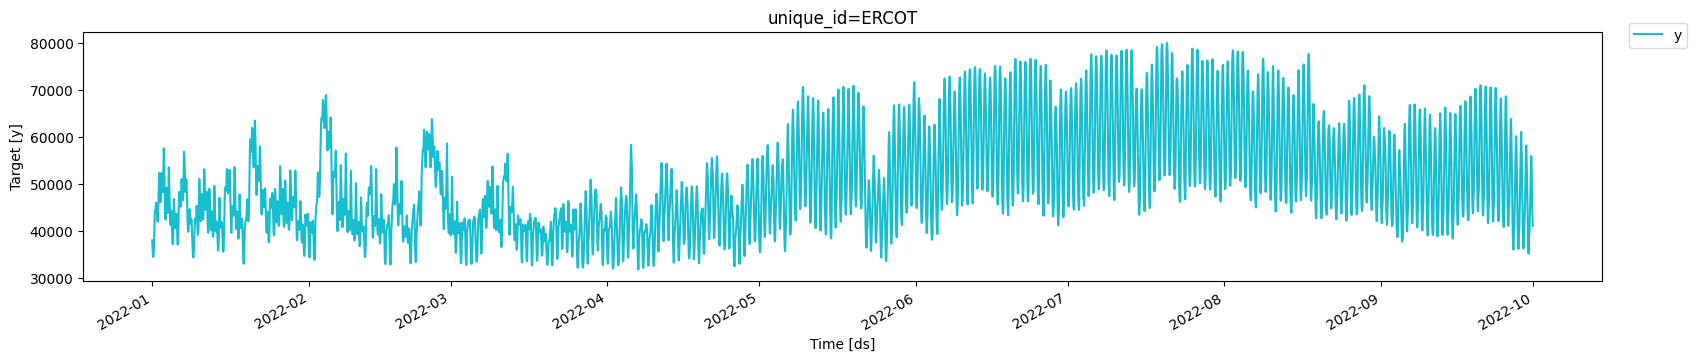

In [5]:
fig = plot_series(Y_df)
fig

# model

In [8]:
mlf = MLForecast(
    models={
        "lgbm": lgb.LGBMRegressor(verbosity=-1)
    },
    freq=freq,
    lags=range(1, 25),
    target_transforms=[Differences([24])],
)

In [10]:
prep = mlf.preprocess(Y_df)
prep.head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
8808,ERCOT,2022-01-03 00:00:00,5654.989845,5597.671101,5913.203269,6548.843168,6595.715399,6476.706722,5604.389423,3760.920931,1952.662936,1949.294808,2695.973499,4424.417670,6711.181412,9261.247749,12148.905430,14345.822153,15231.118316,14182.735886,12063.890617,10412.175670,8862.044610,7376.057798,6140.599774,5123.023718,4784.825676
8809,ERCOT,2022-01-03 01:00:00,6036.587243,5654.989845,5597.671101,5913.203269,6548.843168,6595.715399,6476.706722,5604.389423,3760.920931,1952.662936,1949.294808,2695.973499,4424.417670,6711.181412,9261.247749,12148.905430,14345.822153,15231.118316,14182.735886,12063.890617,10412.175670,8862.044610,7376.057798,6140.599774,5123.023718
8810,ERCOT,2022-01-03 02:00:00,6299.267422,6036.587243,5654.989845,5597.671101,5913.203269,6548.843168,6595.715399,6476.706722,5604.389423,3760.920931,1952.662936,1949.294808,2695.973499,4424.417670,6711.181412,9261.247749,12148.905430,14345.822153,15231.118316,14182.735886,12063.890617,10412.175670,8862.044610,7376.057798,6140.599774
8811,ERCOT,2022-01-03 03:00:00,6504.780552,6299.267422,6036.587243,5654.989845,5597.671101,5913.203269,6548.843168,6595.715399,6476.706722,5604.389423,3760.920931,1952.662936,1949.294808,2695.973499,4424.417670,6711.181412,9261.247749,12148.905430,14345.822153,15231.118316,14182.735886,12063.890617,10412.175670,8862.044610,7376.057798
8812,ERCOT,2022-01-03 04:00:00,6858.989595,6504.780552,6299.267422,6036.587243,5654.989845,5597.671101,5913.203269,6548.843168,6595.715399,6476.706722,5604.389423,3760.920931,1952.662936,1949.294808,2695.973499,4424.417670,6711.181412,9261.247749,12148.905430,14345.822153,15231.118316,14182.735886,12063.890617,10412.175670,8862.044610


# model training

In [12]:
crossvalidation_df = mlf.cross_validation(
    df=Y_df,
    h=horizon,
    n_windows=n_windows,
)
crossvalidation_df

,unique_id,ds,cutoff,y,lgbm
0,ERCOT,2022-09-01 00:00:00,2022-08-31 23:00:00,45482.471757,45685.265537
1,ERCOT,2022-09-01 01:00:00,2022-08-31 23:00:00,43602.658043,43779.819515
2,ERCOT,2022-09-01 02:00:00,2022-08-31 23:00:00,42284.817342,42672.470923
3,ERCOT,2022-09-01 03:00:00,2022-08-31 23:00:00,41663.156771,42091.768192
4,ERCOT,2022-09-01 04:00:00,2022-08-31 23:00:00,41710.621904,42481.403168
...,...,...,...,...,...
715,ERCOT,2022-09-30 19:00:00,2022-09-29 23:00:00,50740.250210,53643.871724
716,ERCOT,2022-09-30 20:00:00,2022-09-29 23:00:00,48768.196369,51552.998323
717,ERCOT,2022-09-30 21:00:00,2022-09-29 23:00:00,46557.510538,48774.836598
718,ERCOT,2022-09-30 22:00:00,2022-09-29 23:00:00,43910.229779,45324.942136


# peak detection

## params

In [13]:
npeaks = 1

In [27]:
crossvalidation_df = crossvalidation_df.reset_index()[["ds", "y", "lgbm"]]
max_day = crossvalidation_df.iloc[crossvalidation_df["y"].argmax()].ds.day
cv_df_day = crossvalidation_df.query("ds.dt.day == @max_day")

In [28]:
# true peak
max_hour = cv_df_day["y"].argmax()
max_hour

16

In [29]:
# predict peak
peaks = cv_df_day["lgbm"].argsort().iloc[-npeaks:].values
peaks

array([16])

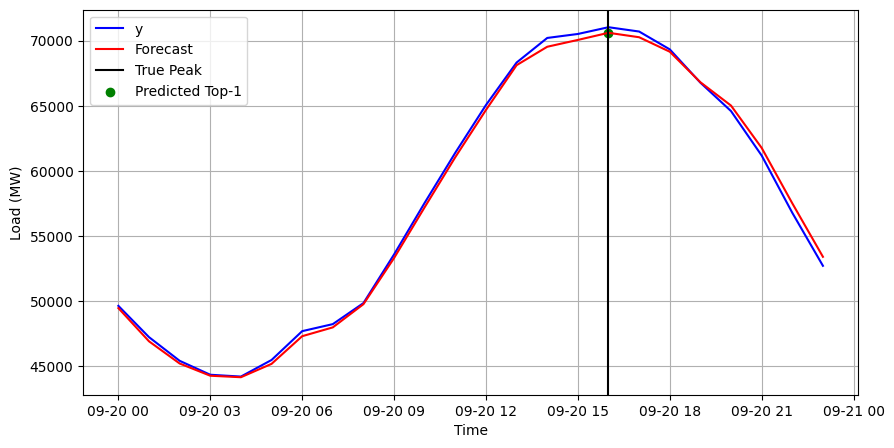

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_df_day['ds'], cv_df_day['y'], label='y', color='blue')
ax.plot(cv_df_day['ds'], cv_df_day['lgbm'], label='Forecast', color='red')
ax.axvline(cv_df_day.iloc[max_hour]['ds'], color='black', label='True Peak')
ax.scatter(cv_df_day.iloc[peaks]['ds'], cv_df_day.iloc[peaks]['lgbm'], color='green', label=f'Predicted Top-{npeaks}')
ax.set(xlabel='Time', ylabel='Load (MW)')
ax.grid()
ax.legend()
plt.show()
# fig.savefig('../../figs/electricity_peak_forecasting__predicted_peak.png', bbox_inches='tight')
plt.close()